In [1]:
import math as m
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import vice
from vice.toolkit import J21_sf_law

In [2]:
OUTPUT_DIR = Path('../src/data/onezone/twoinfall')
END_TIME = 13.2
DT = 0.01
ZONE_WIDTH = 0.1
SIMTIME = np.arange(0, END_TIME+DT, DT)

In [3]:
THIN_DISK_SCALE_RADIUS = 2.5 # kpc
THICK_DISK_SCALE_RADIUS = 2.0 # kpc
THICK_TO_THIN_RATIO = 0.27 # at r = 0

In [4]:
# from vice.yields.sneia import iwamoto99
# from vice.yields.ccsne import WW95
from vice.yields.presets import JW20
# vice.yields.sneia.settings['fe'] *= 0.4
# vice.yields.ccsne.settings['fe'] *= 0.3
# vice.yields.ccsne.settings['o'] *= 0.3
# print(vice.yields.sneia.settings['fe'])
# print(vice.yields.ccsne.settings['fe'])
# print(vice.yields.ccsne.settings['o'])

In [5]:
def second_onset(radius):
    return 4
    # return 2 + radius / 4

In [6]:
class exponential:
    def __init__(self, timescale=1, coeff=1):
        self.timescale = timescale
        self.coeff = coeff
        
    def __call__(self, time):
        return self.coeff / self.timescale * m.exp(-time / self.timescale)

In [7]:
class twoinfall:
    def __init__(self, radius, first_timescale=0.1, second_timescale=4, 
                 second_onset=second_onset, thin_scale=THIN_DISK_SCALE_RADIUS, 
                 thick_scale=THICK_DISK_SCALE_RADIUS):
        thin_to_thick = m.exp(radius * (1 / thick_scale - 1 / thin_scale)) 
        thin_to_thick /= THICK_TO_THIN_RATIO
        self.second_onset = second_onset(radius)
        self.first = exponential(
            timescale = first_timescale,
            coeff = 1 / (1 - m.exp(-END_TIME / first_timescale))
        )
        self.second = exponential(
            timescale = second_timescale,
            coeff = thin_to_thick / (1 - m.exp(
                -(END_TIME - self.second_onset) / second_timescale
            ))
        )
        
    def __call__(self, time):
        ifr = self.first(time)
        if time >= self.second_onset:
            ifr += self.second(time - self.second_onset)
        return ifr

In [8]:
def gradient(radius):
    return (
        m.exp(-radius / THIN_DISK_SCALE_RADIUS) +
        THICK_TO_THIN_RATIO * m.exp(-radius / THICK_DISK_SCALE_RADIUS)
    )

class twoinfall_gradient(twoinfall):
    def __init__(self, radius, dr=ZONE_WIDTH, **kwargs):
        super().__init__(radius, **kwargs)
        area = m.pi * ((radius + dr)**2 - radius**2)
        self.first.coeff *= area * gradient(radius)
        self.second.coeff *= area * gradient(radius)

In [9]:
class twoinfall_tau_star(J21_sf_law):
    def __init__(self, radius, dr=ZONE_WIDTH, mode="ifr", second_onset=second_onset, **kwargs):
        self.radius = radius
        area = m.pi * ((radius + dr)**2 - radius**2)
        self.second_onset = second_onset(radius)
        super().__init__(area, mode = mode, **kwargs)
        
    def __call__(self, time, mgas):
        mgas_dependence = super().__call__(time, mgas) / self.molecular(time)
        return mgas_dependence * self.time_dependence(time)

    def time_dependence(self, time):
        if time < self.second_onset:
            # return 1 / self.sfe1
            return 1 / 2
        else:
            # return 1 / self.sfe2
            return 1
      
    @property
    def sfe1(self):
        if self.radius < 8.:
            return 4 - (self.radius / 4)
        else:
            return 2
        
    @property
    def sfe2(self):
        return max(2 - (self.radius / 8), 1e-6)

In [10]:
class twoinfall_inflow_metallicity:
    def __init__(self, radius, rmax=6, Z_solar=0.014,
                 second_infall_feh=-0.5, second_onset=second_onset):
        if radius <= rmax:
            self.second_inflow_metallicity = Z_solar * 10. ** second_infall_feh
        else:
            self.second_inflow_metallicity = 0.
        self.second_onset = second_onset(radius)
            
    def __call__(self, time):
        if time < self.second_onset:
            return 0.
        else:
            return self.second_inflow_metallicity

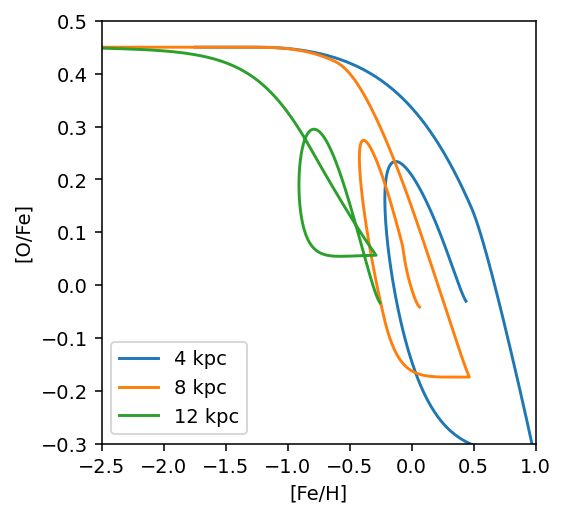

In [11]:
for galr in [4, 8, 12]:
    sz = vice.singlezone(
        name=str(OUTPUT_DIR / f'twoinfall{galr:02d}'), 
        func=twoinfall_gradient(galr, first_timescale=0.1, second_timescale=4), 
        tau_star=twoinfall_tau_star(galr),
        mode='ifr',
        eta=vice.milkyway.default_mass_loading(galr),  
        Mg0=0,
        elements=('fe', 'o'),
        dt=DT,
        recycling='continuous',
        RIa=exponential(timescale=1.5),
        delay=0.04,
        schmidt=False,
        # Zin={},
        # Z_solar = 0.014
    )
    # sz.Zin['fe'] = twoinfall_inflow_metallicity(galr, second_infall_feh=-1.5)
    # sz.Zin['o'] = twoinfall_inflow_metallicity(galr, second_infall_feh=-0.5)
    sz.run(SIMTIME, overwrite=True)

fig, ax = plt.subplots(figsize=(4, 4), dpi=140)
for galr in [4, 8, 12]:
    hist = vice.history(str(OUTPUT_DIR / f'twoinfall{galr:02d}'))
    ax.plot(hist['[fe/h]'], hist['[o/fe]'], label='%s kpc' % galr)
ax.set_xlim((-2.5, 1))
ax.set_ylim((-0.3, 0.5))
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[O/Fe]')
ax.legend()
plt.show()

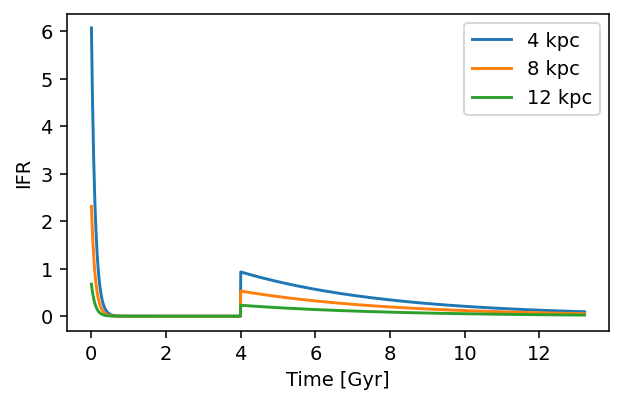

In [12]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=140)
for galr in [4, 8, 12]:
    hist = vice.history(str(OUTPUT_DIR / f'twoinfall{galr:02d}'))
    ax.plot(hist['time'], hist['ifr'], label='%s kpc' % galr)
ax.set_xlabel('Time [Gyr]')
ax.set_ylabel('IFR')
ax.legend()
plt.show()

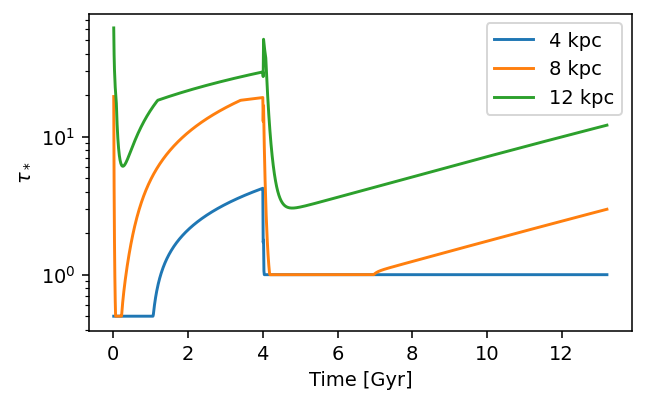

In [13]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=140)
for galr in [4, 8, 12]:
    hist = vice.history(str(OUTPUT_DIR / f'twoinfall{galr:02d}'))
    ax.plot(hist['time'][1:], [hist['mgas'][i+1] / hist['sfr'][i+1] * 1e-9 for i in range(len(hist['sfr'])-1)], label='%s kpc' % galr)
ax.set_xlabel('Time [Gyr]')
ax.set_ylabel(r'$\tau_*$')
ax.set_yscale('log')
ax.legend()
plt.show()

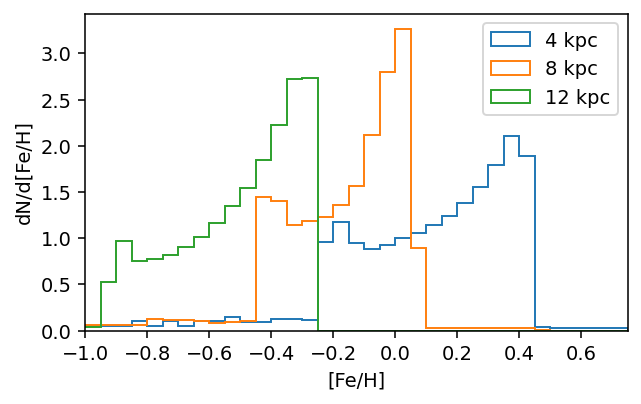

In [14]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=140)
for galr in [4, 8, 12]:
    mdf = vice.mdf(str(OUTPUT_DIR / f'twoinfall{galr:02d}'))
    bins = mdf['bin_edge_left'] + mdf['bin_edge_right'][-1:]
    ax.hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], label='%s kpc' % galr, histtype='step')
ax.set_xlim((-1., 0.75))
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('dN/d[Fe/H]')
ax.legend()
plt.show()

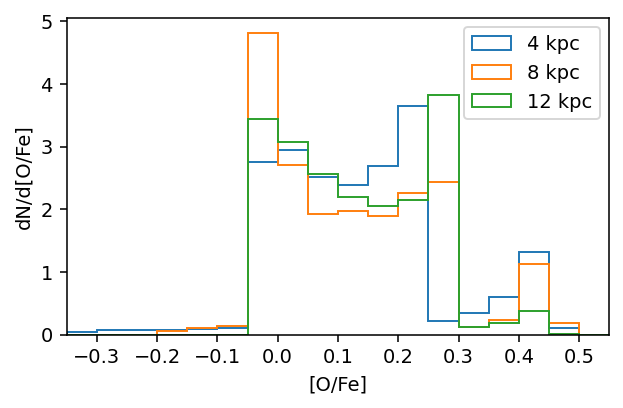

In [15]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=140)
for galr in [4, 8, 12]:
    mdf = vice.mdf(str(OUTPUT_DIR / f'twoinfall{galr:02d}'))
    bins = mdf['bin_edge_left'] + mdf['bin_edge_right'][-1:]
    ax.hist(bins[:-1], bins, weights=mdf['dn/d[o/fe]'], label='%s kpc' % galr, histtype='step')
ax.set_xlim((-0.35, 0.55))
ax.set_xlabel('[O/Fe]')
ax.set_ylabel('dN/d[O/Fe]')
ax.legend()
plt.show()